# This is homework of forth week.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let's start with loading the dataframe

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')

Explore data

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


<AxesSubplot:xlabel='card', ylabel='Count'>

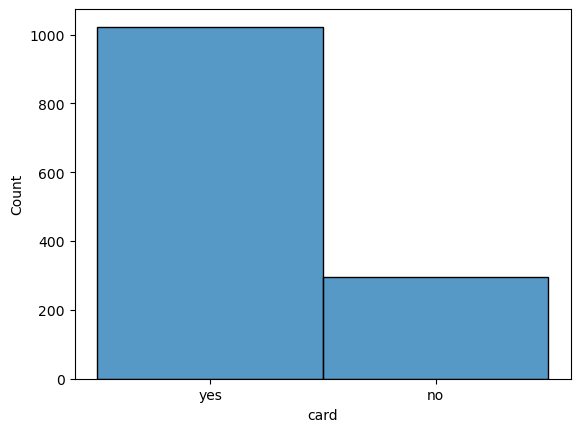

In [4]:
sns.histplot(df.card)

# Data Preparation

In [9]:
df['card_bin'] = np.where(df.card=='yes',1,0)

In [11]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2/(0.2+0.6), random_state=1)
print(len(df_train), len(df_val), len(df_test))
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
y_train = df_train.card_bin.values
y_val = df_val.card_bin.values
y_test = df_test.card_bin.values
del df_train['card_bin']
del df_val['card_bin']
del df_test['card_bin']

791 264 264


# Question 1

In [40]:
numerical_cols = df_train.dtypes[(df_train.dtypes == np.float64) | (df_train.dtypes == np.int64)].index
numerical_cols = list(numerical_cols)

In [41]:
numerical_cols

['reports',
 'age',
 'income',
 'share',
 'expenditure',
 'dependents',
 'months',
 'majorcards',
 'active']

In [42]:
from sklearn.metrics import roc_auc_score
for col in numerical_cols:
    roc_auc = roc_auc_score(y_train, df_train[col])
    if roc_auc < 0.5:
        roc_auc = 1 - roc_auc
    print(col,roc_auc)

reports 0.7166629860689376
age 0.5240020979407055
income 0.5908049467233478
share 0.989183643423692
expenditure 0.991042345276873
dependents 0.5327757227773791
months 0.5294217780967629
majorcards 0.5343859842838476
active 0.6043173411362006


share 0.989183643423692

# Training the model

In [43]:
train_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [44]:
#One Hot Encoding
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)
train_dict = df_train[train_cols].to_dict(orient='records')
dv.fit_transform(train_dict)
X_train = dv.fit_transform(train_dict)

val_dict = df_val[train_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[train_cols].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [45]:
X_train[0,:]

array([1.700000e+01, 4.050000e+01, 1.000000e+00, 0.000000e+00,
       4.012800e+00, 1.000000e+00, 1.200000e+01, 1.000000e+00,
       0.000000e+00, 3.000000e+00, 1.000000e+00, 0.000000e+00,
       2.990431e-04])

In [59]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

# Question 2

In [60]:
y_pred_val = model.predict(X_val)

In [66]:
print('roc_auc on val ds:',round(roc_auc_score(y_val, y_pred_val),3))

roc_auc on val ds: 0.974


# Question 3

In [69]:
#y_pred_val_pb = model.predict_proba(X_val)[:, 1]
#y_pred_val_th = (y_pred_val_pb >= 0.5)
#print('roc_auc on val ds:',round(roc_auc_score(y_val, y_pred_val_th),3))

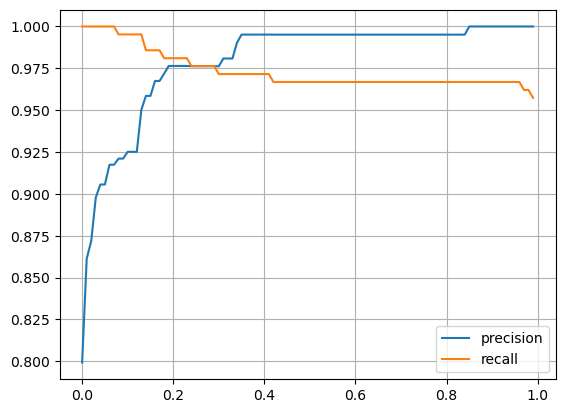

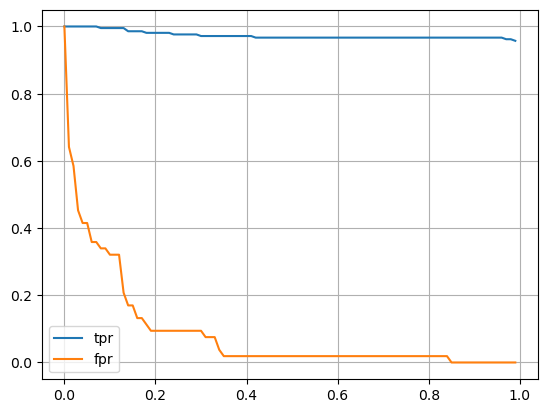

In [92]:
y_pred_val_pb = model.predict_proba(X_val)[:, 1]
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
threshold_list = np.arange(0.0,1.0,0.01)
precision_list = []
recall_list = []
tpr_list = []
fpr_list = []
for threshold in threshold_list:
    y_pred_val_th = (y_pred_val_pb >= threshold)
    
    predict_positive = (y_pred_val_th == 1)
    predict_negative = (y_pred_val_th == 0)
    
    tp = (predict_positive & actual_positive).sum()#true positive
    tn = (predict_negative & actual_negative).sum()#true negative
    fp = (predict_positive & actual_negative).sum()#false positive
    fn = (predict_negative & actual_positive).sum()#false negative
    
    p = tp / (tp + fp)# precision
    r = tp / (tp + fn)# recall
    
    precision_list.append(p)
    recall_list.append(r)
    tpr_list.append(tp/(tp+fn))
    fpr_list.append(fp/(fp+tn))
plt.plot(threshold_list,precision_list,label='precision')
plt.plot(threshold_list,recall_list,label='recall')
plt.legend()
plt.grid()
plt.figure()
plt.plot(threshold_list,tpr_list,label='tpr')
plt.plot(threshold_list,fpr_list,label='fpr')
plt.legend()
plt.grid()

In [77]:
# intersection on threshold = 0.3

# Question 4

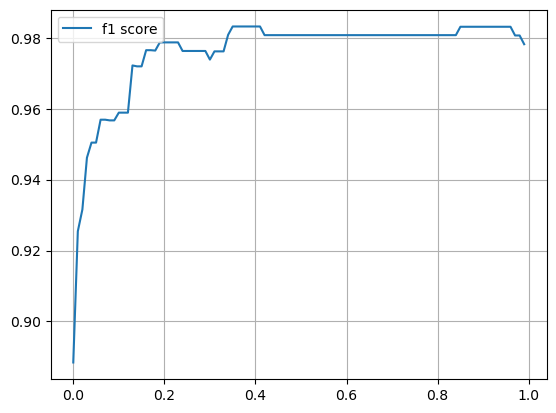

In [82]:
f1_list = []
f1_max = 0
th_max = 0
for idx,threshold in enumerate(threshold_list):
    p = precision_list[idx]
    r = recall_list[idx]
    f1 = 2*(p*r)/(p+r)
    if f1 > f1_max:
        f1_max = f1
        th_max = threshold
    f1_list.append(f1)
plt.plot(threshold_list,f1_list,label='f1 score')
plt.legend()
plt.grid()

In [84]:
f1_max,th_max

(0.9832134292565947, 0.35000000000000003)

* at 0.4 f1 is max

# Question 5

In [86]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
roc_auc_list = []
for train_idx, val_idx in kfold.split(df_full_train):
    # setting train val ds
    df_train_kfold = df_full_train.iloc[train_idx]
    df_val_kfold = df_full_train.iloc[val_idx]

    # setting ground truth y
    y_train_kfold = df_train_kfold.card_bin.values
    y_val_kfold = df_val_kfold.card_bin.values

    # one hot encoding on train
    dv_kfold = DictVectorizer(sparse=False)
    train_kfold_dict = df_train_kfold[train_cols].to_dict(orient='records')
    dv_kfold.fit_transform(train_kfold_dict)
    X_train_kfold = dv.fit_transform(train_kfold_dict)
    
    # apply one hot encoding on val
    val_kfold_dict = df_val_kfold[train_cols].to_dict(orient='records')
    X_val_kfold = dv_kfold.transform(val_kfold_dict)
    
    # train LogReg on train
    model_kfold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_kfold.fit(X_train_kfold, y_train_kfold)
    
    y_val_kfold_pred = model_kfold.predict(X_val_kfold)
    roc_auc = roc_auc_score(y_val_kfold, y_val_kfold_pred)
    roc_auc_list.append(roc_auc)

    print('roc_auc',roc_auc)
    
print(np.std(roc_auc_list))

roc_auc 0.9675387596899225
roc_auc 0.984375
roc_auc 0.9739789196310935
roc_auc 0.9908536585365854
roc_auc 1.0
0.011596469127928001


# Question 6

In [91]:
C_list = [0.01, 0.1, 1, 10]
for C in C_list:
    kfold = KFold(n_splits=5, shuffle=True, random_state=2)
    roc_auc_list = []
    for train_idx, val_idx in kfold.split(df_full_train):
        # setting train val ds
        df_train_kfold = df_full_train.iloc[train_idx]
        df_val_kfold = df_full_train.iloc[val_idx]

        # setting ground truth y
        y_train_kfold = df_train_kfold.card_bin.values
        y_val_kfold = df_val_kfold.card_bin.values

        # one hot encoding on train
        dv_kfold = DictVectorizer(sparse=False)
        train_kfold_dict = df_train_kfold[train_cols].to_dict(orient='records')
        dv_kfold.fit_transform(train_kfold_dict)
        X_train_kfold = dv.fit_transform(train_kfold_dict)

        # apply one hot encoding on val
        val_kfold_dict = df_val_kfold[train_cols].to_dict(orient='records')
        X_val_kfold = dv_kfold.transform(val_kfold_dict)

        # train LogReg on train
        model_kfold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_kfold.fit(X_train_kfold, y_train_kfold)

        y_val_kfold_pred = model_kfold.predict(X_val_kfold)
        roc_auc = roc_auc_score(y_val_kfold, y_val_kfold_pred)
        roc_auc_list.append(roc_auc)

        print('roc_auc',roc_auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(roc_auc_list), np.std(roc_auc_list)))

roc_auc 0.9857142857142858
roc_auc 0.9908536585365854
roc_auc 0.9589317208364827
roc_auc 0.984472049689441
roc_auc 0.9969325153374233
C=0.01 0.983 +- 0.013
roc_auc 0.9857142857142858
roc_auc 0.9908536585365854
roc_auc 0.968190980095742
roc_auc 0.984472049689441
roc_auc 0.9969325153374233
C=0.1 0.985 +- 0.010
roc_auc 0.9885714285714285
roc_auc 0.9908536585365854
roc_auc 0.9579868984630889
roc_auc 0.984472049689441
roc_auc 0.9969325153374233
C=1 0.984 +- 0.014
roc_auc 0.9885714285714285
roc_auc 0.9908536585365854
roc_auc 0.9477828168304359
roc_auc 0.9744720496894409
roc_auc 0.9969325153374233
C=10 0.980 +- 0.018


* best C = 0.01